In [ ]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

from datetime import datetime


pd.set_option("display.max_columns", None)

In [ ]:
# load dataset
data = pd.read_json('../../data/TRAINING_dataset.json')
data

In [ ]:
X = data.drop('stakeholder_category', axis=1) # Features
y = data['stakeholder_category'] # Target variable

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
def run_experiment(criterion, splitter, min_samples_split, min_samples_leaf, max_depth):
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(criterion=criterion,
                                 splitter=splitter,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_depth=max_depth)

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    return metrics.accuracy_score(y_test, y_pred)

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

* tune hyperparams

In [ ]:
maxi = [0,0]
for depth in range(1,50):
    print(depth)    
    for split in range(2,10):
        for leaf in range(2,10):
            
            score = run_experiment("gini", 'random', split, leaf, depth)
        
            if score > maxi[0]:
                maxi = [score, split, leaf, depth]
maxi

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", splitter='best', min_samples_split=maxi[1], min_samples_leaf=maxi[2], max_depth=maxi[3])

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)



now = datetime.now().strftime("%Y%m%d-%H%M%S")
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('../../exp/decision_forest/decision_forest' + now + '.png')
Image(graph.create_png())

* get important features

In [ ]:
feat_importance = clf.tree_.compute_feature_importances(normalize=False)
np.savetxt('../../data/feat_importance.csv', np.array([np.array(X.columns),feat_importance]).T, delimiter=',', fmt='%s')

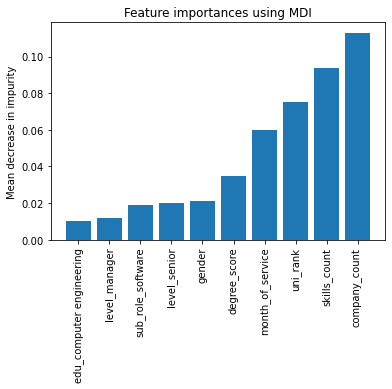

In [ ]:
feat_imp = []
feat = []
for idx, imp in enumerate(feat_importance):
    if imp > 0.01:
        feat.append(X.columns[idx])
        feat_imp.append(round(imp,3))

sort_idx = np.argsort(feat_imp)
feat_imp = [feat_imp[x] for x in sort_idx] 
feat = [feat[x] for x in sort_idx] 

now = datetime.now().strftime("%Y%m%d-%H%M%S")
plt.bar(feat, feat_imp)
plt.xticks(rotation=90)
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.savefig('../../exp/decision_forest/feature_importance' + now + '.png', 
            bbox_inches = "tight", 
            facecolor='white')
plt.show()


* get "true" accuracy with cross validation
* tune  *tree_depth*

The depth-24 tree achieves the best mean cross-validation accuracy 63.1037 +/- 5.46346% on training dataset


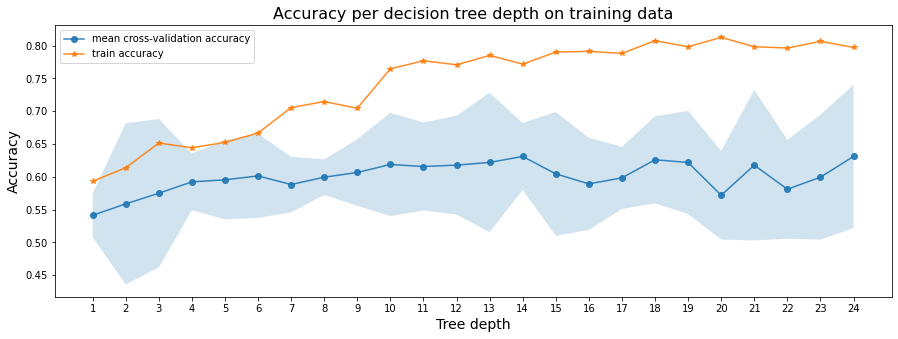

In [ ]:
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(criterion="gini", 
                                            splitter='random', 
                                            min_samples_split=maxi[1], 
                                            min_samples_leaf=maxi[2],
                                            max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    #ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X,
                                                                                        y,#
                                                                                        sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

